## Loading Libraries

In [2]:
library(RWeka)
library(partykit)
library(rpart)
library(rpart.plot)
library(dplyr)
library(Metrics)

## Loading Relative CPU Performance dataset

In [3]:
data <- read.arff(system.file("arff", "cpu.arff", package = "RWeka"))

In [4]:
head(data)

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,125,256,6000,256,16,128,198
2,29,8000,32000,32,8,32,269
3,29,8000,32000,32,8,32,220
4,29,8000,32000,32,8,32,172
5,29,8000,16000,32,8,16,132
6,26,8000,32000,64,8,32,318


## Train Test Split

In [5]:
set.seed(25)
rows = sample(nrow(data))
data = data[rows,]


train_indices = 1:round(0.8 * nrow(data))
train_data = data[train_indices,]

test_indices = (round(0.8 * nrow(data)) + 1):nrow(data)
test_data = data[test_indices,]

test_X = test_data %>% select(-c("class")) 
test_y = test_data %>% select(c("class"))

## CART  

In [6]:
cart_tree = rpart(class ~ ., data = train_data, method = "anova")

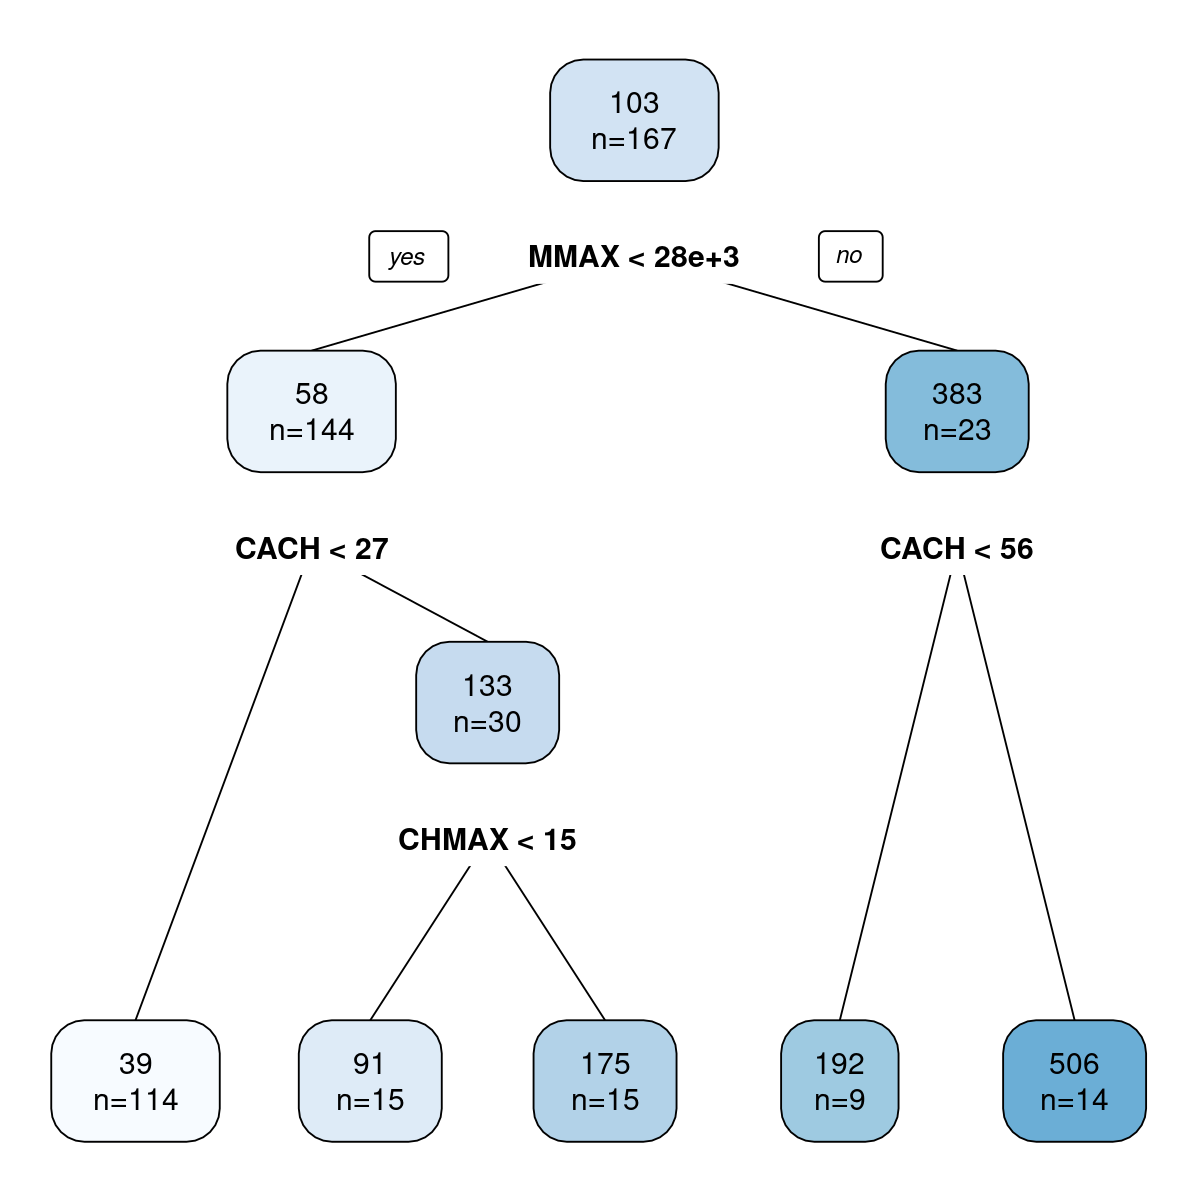

In [7]:
options(repr.plot.width=10, repr.plot.height=10)
rpart.plot(cart_tree, uniform = T, cex = 1.5, branch = 0, extra = 1)

## Model Trees

#### Control options for model trees
- `N: Use unpruned tree/rules`
- `U: Use unsmoothed predictions`
- `R: Build regression tree/rule rather than a model tree/rule`
- `M: Set minimum number of instances per leaf`

In [8]:
model_tree_unpruned_unsmoothed <- M5P(class ~ ., data = train_data, control=Weka_control(U=T, N = T, M = 10))

model_tree_unpruned <- M5P(class ~ ., data = train_data, control=Weka_control(U=F, N = T, M = 10))

model_tree_unsmoothed <- M5P(class ~ ., data = train_data, control=Weka_control(U=T, N = F, M = 10))

model_tree <- M5P(class ~ ., data = train_data, control=Weka_control(U=F, N = F, M = 10))

## Unpruned and Unsmoothed model tree

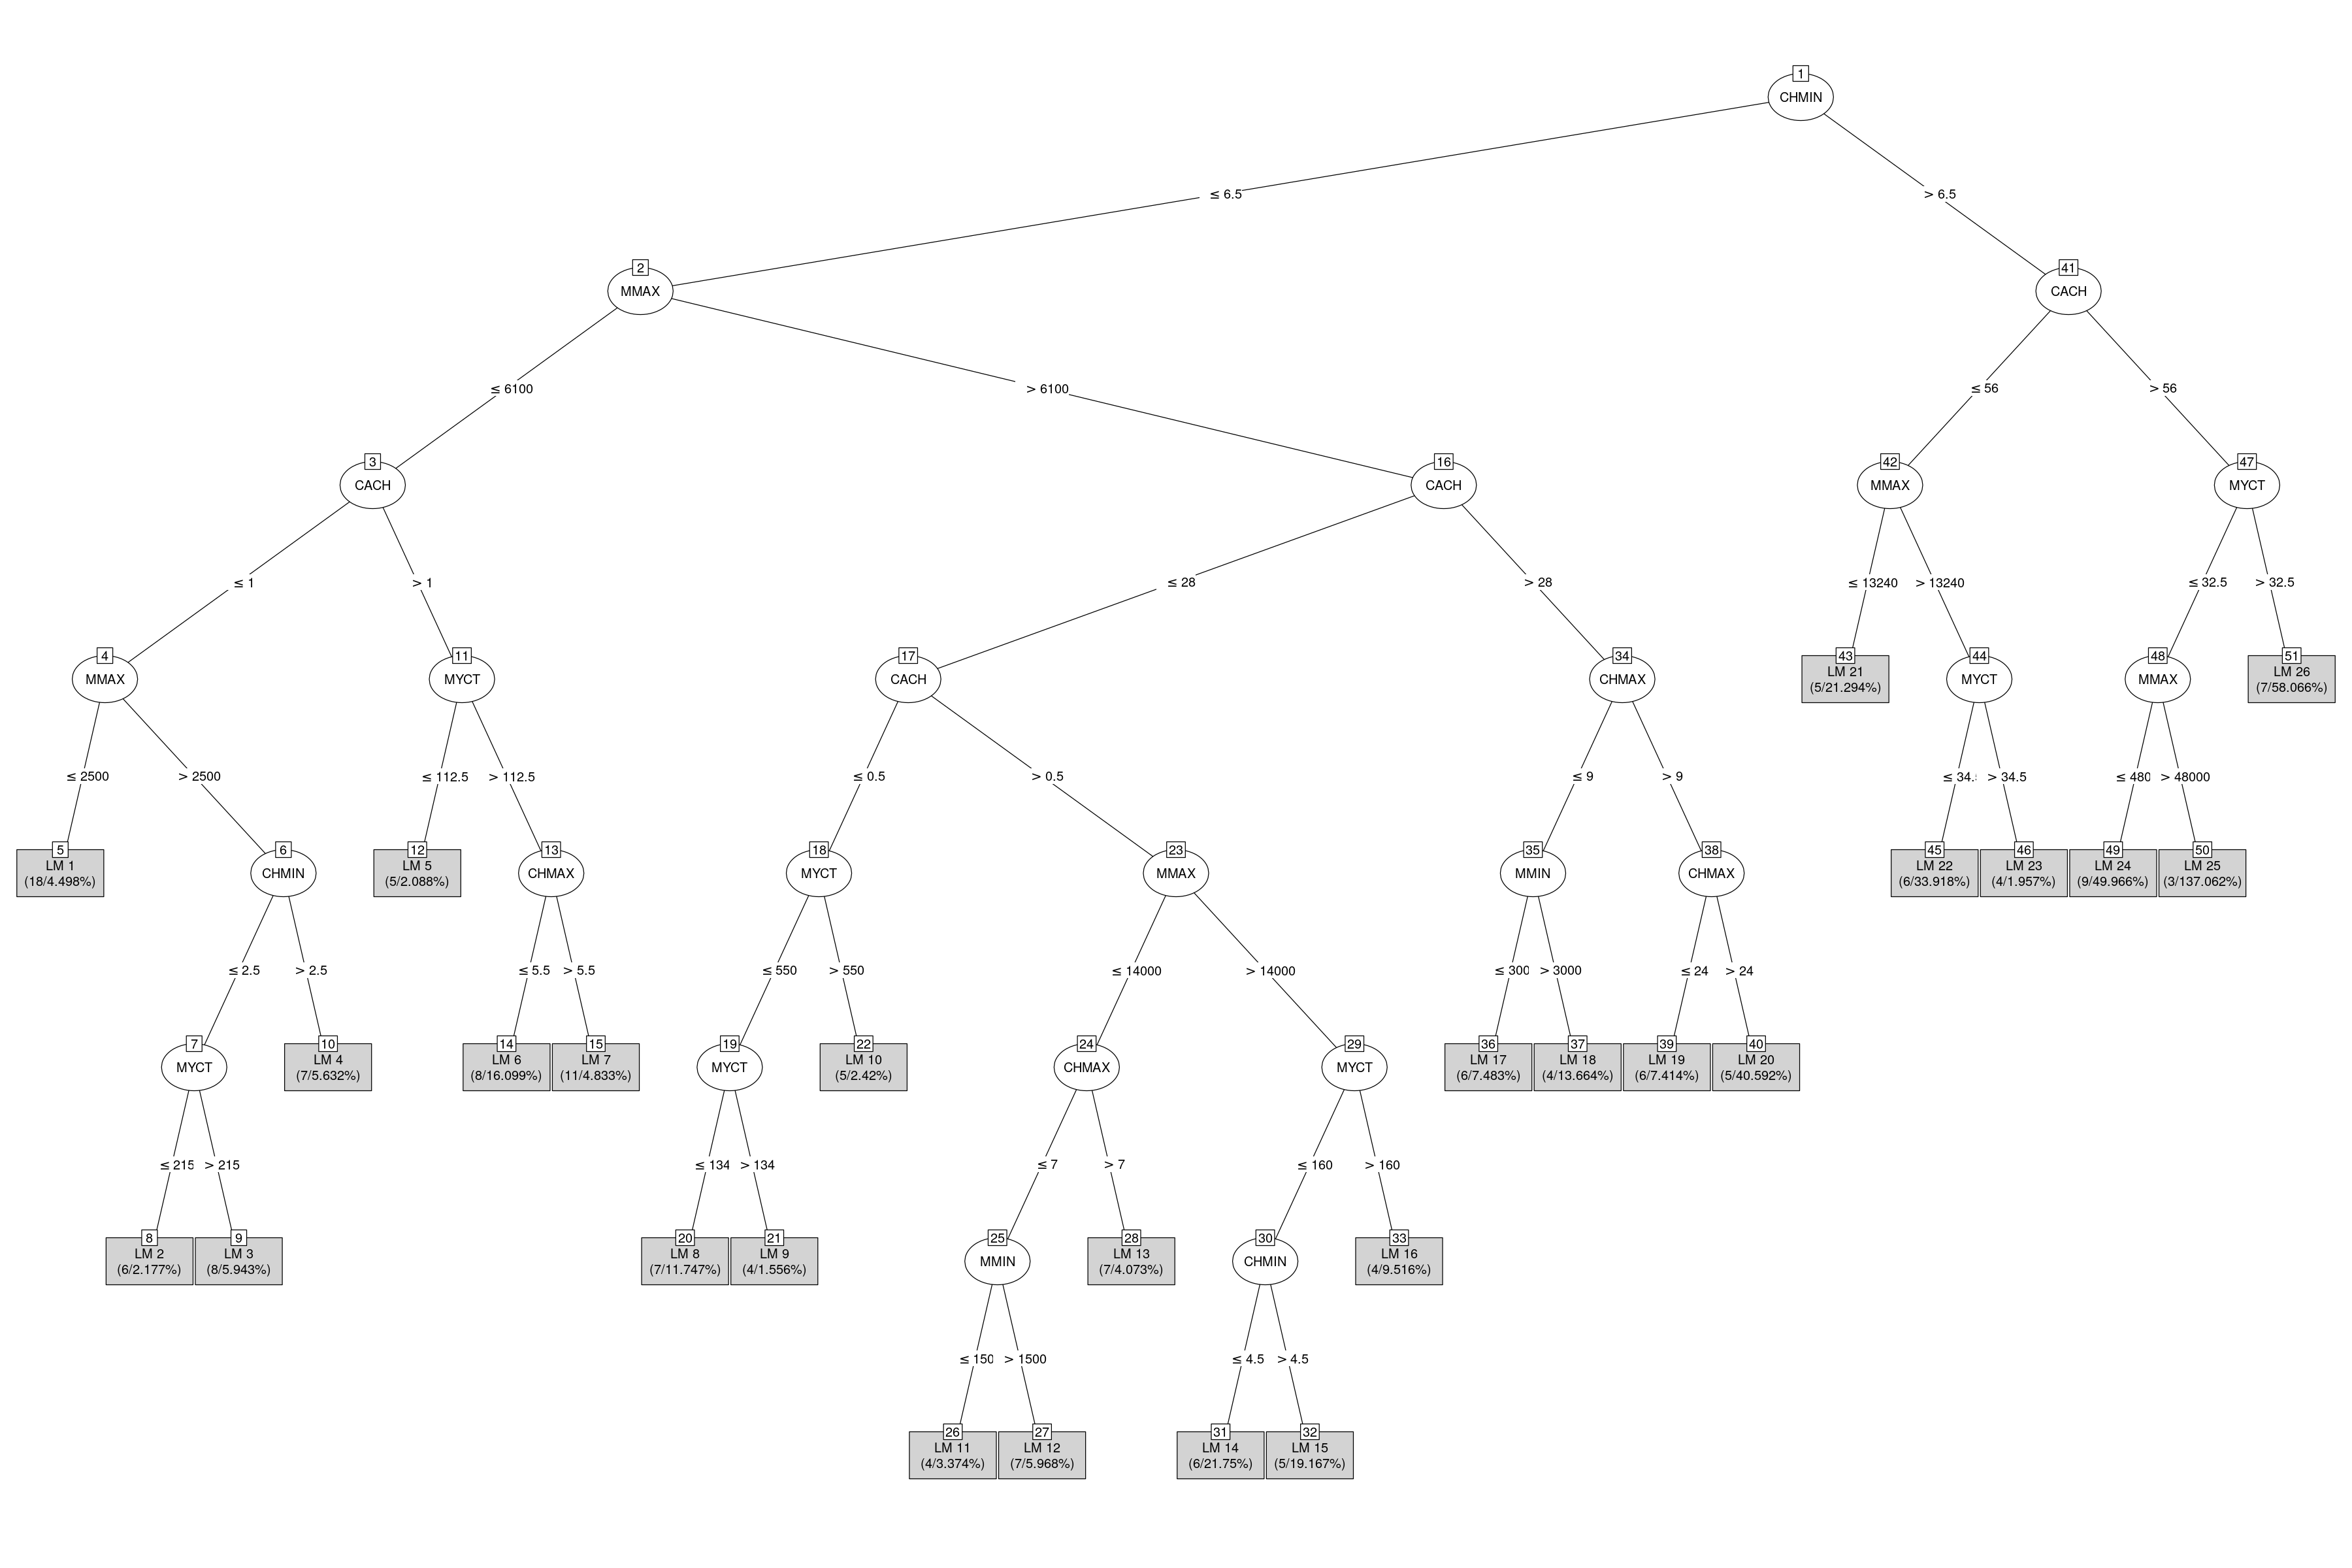

In [9]:
options(repr.plot.width=30, repr.plot.height=20)
plot(model_tree_unpruned_unsmoothed)

## Pruned and Smoothed model tree

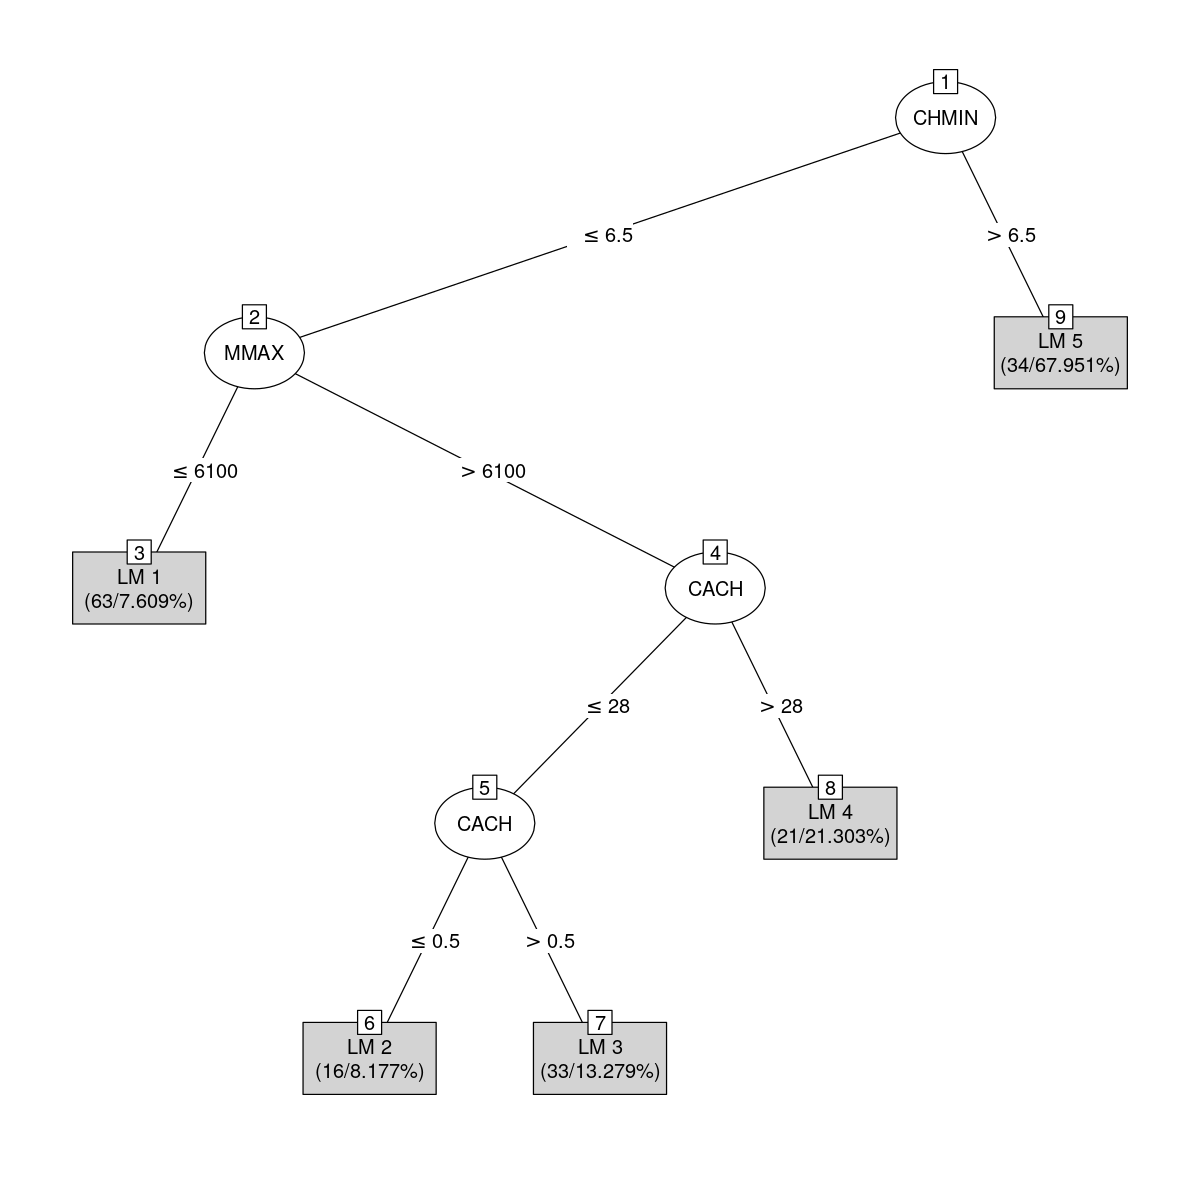

In [10]:
options(repr.plot.width=10, repr.plot.height=10)
plot(model_tree)

In [11]:
summary(model_tree)


=== Summary ===

Correlation coefficient                  0.9179
Mean absolute error                     42.2712
Root mean squared error                 74.1291
Relative absolute error                 44.4107 %
Root relative squared error             48.3603 %
Total Number of Instances              167     

## Model tree structure and Linear Models with Parameters

In [12]:
model_tree

M5 pruned model tree:
(using smoothed linear models)

CHMIN <= 6.5 : 
|   MMAX <= 6100 : LM1 (63/7.609%)
|   MMAX >  6100 : 
|   |   CACH <= 28 : 
|   |   |   CACH <= 0.5 : LM2 (16/8.177%)
|   |   |   CACH >  0.5 : LM3 (33/13.279%)
|   |   CACH >  28 : LM4 (21/21.303%)
CHMIN >  6.5 : LM5 (34/67.951%)

LM num: 1
class = 
	0.0044 * MMIN 
	+ 0.0041 * MMAX 
	+ 0.0009 * CACH 
	+ 2.3606 * CHMIN 
	+ 3.6599

LM num: 2
class = 
	-0.0091 * MYCT 
	- 0.0012 * MMIN 
	+ 0.0037 * MMAX 
	+ 0.0019 * CACH 
	+ 0.5758 * CHMIN 
	+ 15.7432

LM num: 3
class = 
	0.003 * MMIN 
	+ 0.0037 * MMAX 
	+ 0.0017 * CACH 
	+ 0.498 * CHMIN 
	+ 8.3383

LM num: 4
class = 
	-0.0019 * MMIN 
	+ 0.0012 * MMAX 
	+ 0.0016 * CACH 
	+ 0.4592 * CHMIN 
	+ 1.0579 * CHMAX 
	+ 22.2978

LM num: 5
class = 
	0.0132 * MMIN 
	+ 0.0112 * MMAX 
	+ 1.0848 * CACH 
	+ 0.2933 * CHMIN 
	- 63.2357

Number of Rules : 5

## Predicting test data

In [13]:
pred_cart = rpart.predict(cart_tree, newdata = test_X)
pred_m5_unpruned = predict(model_tree_unpruned, newdata = test_X)
pred_m5_unpruned_unsmoothed = predict(model_tree_unpruned_unsmoothed, newdata = test_X)
pred_m5_unsmoothed = predict(model_tree_unsmoothed, newdata = test_X)
pred_m5 = predict(model_tree, newdata = test_X)

## RMSE for all predictions

In [14]:
rmse_list = list(cart = rmse(test_y$class, pred_cart), 
                 m5_unp_unsm = rmse(test_y$class, pred_m5_unpruned_unsmoothed), 
                 m5_unp = rmse(test_y$class, pred_m5_unpruned),
                 m5_unsm = rmse(test_y$class, pred_m5_unsmoothed),
                 m5 = rmse(test_y$class, pred_m5))

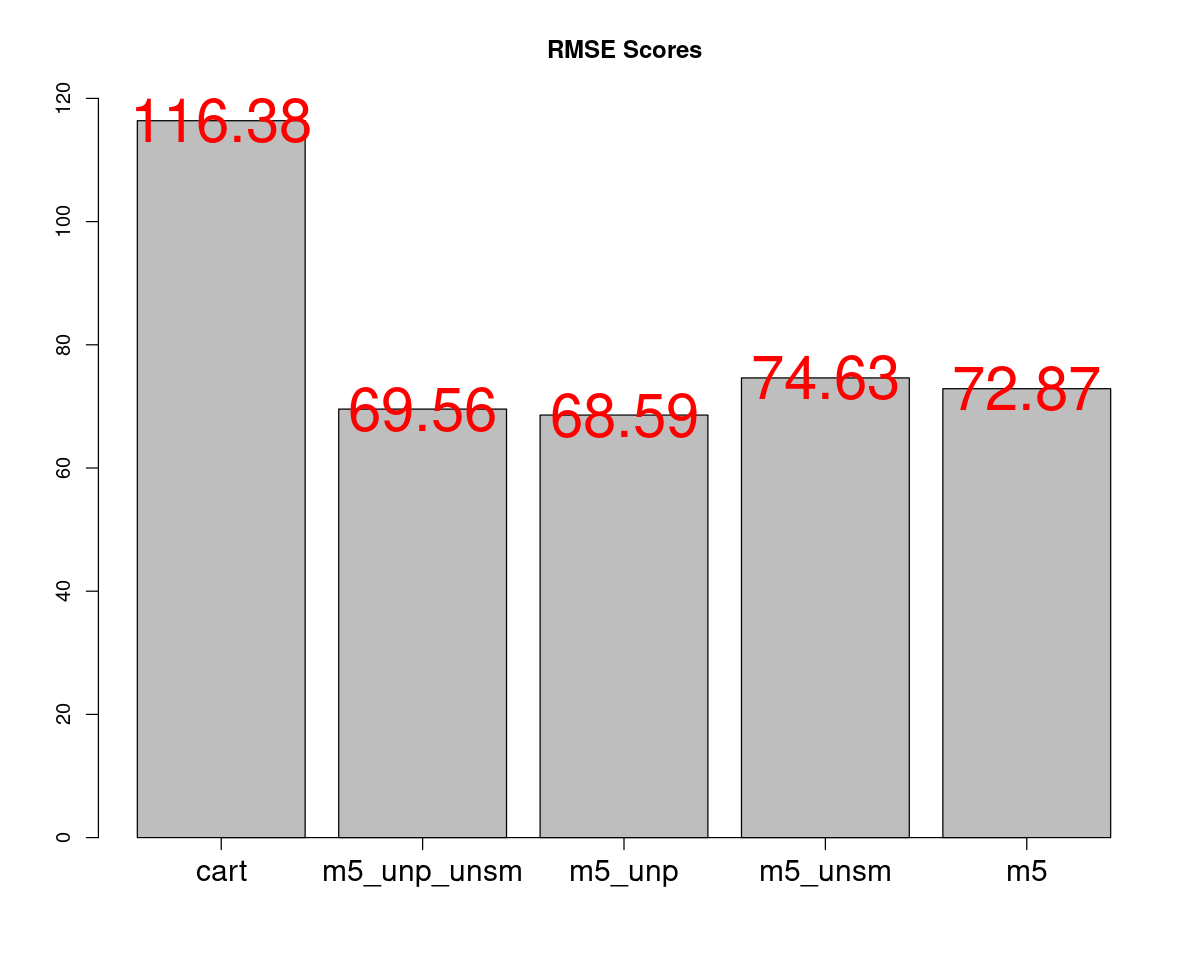

In [15]:
options(repr.plot.width=10, repr.plot.height=8)
bplot_rmse = barplot(unlist(rmse_list), main="RMSE Scores", ylim = c(0,120), xlab = "", xaxt = "n")
text(x = bplot_rmse, y = round(unlist(rmse_list),2), label = round(unlist(rmse_list),2), col = "red", cex = 3)
axis(1, at = bplot_rmse, labels=names(rmse_list), cex.axis=1.5)

## Predicted values

In [16]:
pred_results_df = data.frame(True_y = test_y$class, 
                             predicted_cart = pred_cart,
                             predicted_m5_unpruned = pred_m5_unpruned,
                             predicted_m5_unpruned_unsmoothed = pred_m5_unpruned_unsmoothed,
                             predicted_m5_unsmoothed = pred_m5_unsmoothed,
                             predicted_m5 = pred_m5)
head(pred_results_df, 10)

,True_y,predicted_cart,predicted_m5_unpruned,predicted_m5_unpruned_unsmoothed,predicted_m5_unsmoothed,predicted_m5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,63,175.00000,123.78069,52.60000,91.15419,124.69453
90,66,175.00000,82.69661,160.60000,191.00027,85.71799
171,25,38.55263,16.97758,16.27778,19.50160,18.53823
58,12,38.55263,38.35677,19.20000,18.75142,38.32397
110,18,38.55263,29.33512,33.75000,27.39879,26.67675
114,34,38.55263,35.92809,34.81818,33.25572,35.78462
69,32,38.55263,30.30210,34.42857,33.25572,31.39435
197,307,506.42857,416.15850,273.28571,453.43871,457.79816
56,60,38.55263,53.85148,33.50000,52.43324,55.84159
